<a href="https://colab.research.google.com/github/RoyPoulami/X-axis-parameter-generation-Neurokit/blob/main/R_voltage_calculation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

!mkdir -p ~/.google/carditek-ecg
!cp /content/drive/MyDrive/Colaboratory/dot-google/client_secret.json ~/.google/carditek-ecg

%cd /content/drive/MyDrive/Colaboratory/dot-google/python-client-master/carditek/cloud/client
import buffer
import client 

client = client.Client()

workspace ='/content/drive/My Drive/Colaboratory/Carditek TIFF Files/CAL_PULSE/'
background = '/content/drive/My Drive/Colaboratory/Carditek TIFF Files'
import sys; sys.path.append(workspace)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1q0cNRCNl-FiQ1sdRz_H4Qa7dtYD-81-B/Colaboratory/dot-google/python-client-master/carditek/cloud/client


In [ ]:
# # # # # APKs and libraries calling # # # # # 

from google.colab import files
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
import numpy as np
from scipy import signal
from scipy import signal as sp
import pandas as pd
from scipy.signal import hilbert, savgol_filter
import collections
from numpy import array, sign, zeros
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt



def ecg_filters_V5_01(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  for x in  range(1,len(lead_data),1):
      if (lead_data[x] == 0):
       lead_data[x] = lead_data[x-1]
 
 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
  #b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal 
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter 
  h, g = sp.butter(4, [145/500] , btype='low', analog=False)

  filt_BW = sp.filtfilt(b, a, lead_data)
  filt_50 = sp.lfilter(d, c, filt_BW); filt_100 = sp.lfilter(f, e, filt_50)
  filt_LP = sp.lfilter(h, g, filt_50)
  smoothed = sp.savgol_filter(filt_LP, window_length =29, polyorder = 3)
  return smoothed

#####################################
###### Defining Frequency, time stamp, Frequency, mac ID ######
Fs = 1000
ts = 1672825365
frequency = 1
print('Signal Frequency -',frequency,' Hz')
BW = int ((Fs)-1)
macId = 'E4:E1:12:C4:CD:DE'
limbleads = 1
vleads = 1
#####################################

buffer = client.fetch(macId,ts)
frame = buffer.frame

Lead1 = frame.i;Lead2 = frame.ii; v1 = frame.v1; v2 = frame.v2;v3 = frame.v3;v4 = frame.v4;v5 = frame.v5;v6 = frame.v6    ##############   Defining leads through Python library 

gain = 1;
Lead1 = ((Lead1)*0.000286)*((gain));   ##-3  ############## ADS to Mili Volt conversion 
Lead2 = ((Lead2)*0.000286)*((gain)); ############## ADS to Mili Volt conversion 
v1 = ((v1)*0.000286)*((gain));v2 = ((v2)*0.000286)*((gain));v3 = ((v3)*0.000286)*((gain));   ############## ADS to Mili Volt conversion  
v4 = ((v4)*0.000286)*((gain));v5 = ((v5)*0.000286)*((gain));v6 = ((v6)*0.000286)*((gain));  ############## ADS to Mili Volt conversion 
Lead1 = ecg_filters_V5_01(Lead1); Lead2 = ecg_filters_V5_01(Lead2); ############## Version 5 filter according to IEC 60601-2-25
Leadv1 = ecg_filters_V5_01(v1); Leadv2 = ecg_filters_V5_01(v2); Leadv3 = ecg_filters_V5_01(v3); ############## Version 5 filter according to IEC 60601-2-25
Leadv4 = ecg_filters_V5_01(v4); Leadv5 = ecg_filters_V5_01(v5); Leadv6 = ecg_filters_V5_01(v6); ############## Version 5 filter according to IEC 60601-2-25
Lead3 = Lead2-Lead1

##### Function for Notch Filter 
def func1(freq,sig,sd,z):

    quality = 100 #for mV signals put 100, 
    notchfreq1 = 50
    notchfreq2 = 66

    startVal = sd
    interval = int(np.round(1000/freq))
    MaxValue = []
    MinValue = []

##### notch filter to remove 50 Hz and 66 Hz 
    b, a = sp.iirnotch(notchfreq1, quality, 1000); sig = sp.filtfilt(b, a, sig)  ######## 50Hz filter
    d, c = sp.iirnotch(notchfreq2, quality, 1000); sig = sp.filtfilt(d, c, sig) ##########66hz filter

    for i in range(1,10):
        x1 = np.max(sig[startVal:(startVal+interval)]) ########## Max value finding in defined window 
        y1 = np.min(sig[startVal:(startVal+interval)]) ########## Min value finding in defined window
        MaxValue.append(x1) ########## Adding max values 
        MinValue.append(y1)  ########## Adding min values
        startVal = startVal+interval
        
    x = np.asarray(MaxValue)  ########## Array of Max value
    y = np.asarray(MinValue)  ########## Array of Min value
    z = str(z)
    peak_to_peak = np.abs(x-y)
    adc_range_average = np.mean(peak_to_peak)
    volt_range = peak_to_peak*0.000286 ########## Finding peak to peak voltages in mili volt 
    volt_range_average = np.mean(volt_range) ########## Mean voltage in Mili Volt 
    #print('X',x)
    #print('Y',y)
    #print(peak_to_peak)
    print(z,'10 Peak to Peak Values array - ',peak_to_peak)
    print(z,'ADC Average Range - %f'%(adc_range_average))
    print(z,'Average Voltage - %f'%(volt_range_average),'mV')
          
    return sig #peak_to_peak,adc_range_average,volt_range_average

xxx = 1000
########## Pre arrangements of Leads 
Lead1 = func1(frequency,Lead1,xxx,'I')
Lead2 = func1(frequency,Lead2,xxx,'II')
# Lead3= func1(frequency,iii,xxx,'III')
Leadv1= func1(frequency,v1,xxx,'V1')
Leadv2= func1(frequency,v2,xxx,'V2')
Leadv3= func1(frequency,v3,xxx,'V3')
Leadv4= func1(frequency,v4,xxx,'V4')
Leadv5= func1(frequency,v5,xxx,'V5')
Leadv6= func1(frequency,v6,xxx,'V6')

########## Defining layout for plotting 
if limbleads == 1:
  fig = make_subplots(rows=3, cols=1,subplot_titles=("Lead I","Lead II","Lead III"))
  fig.add_trace(go.Scatter(x=((np.arange(1,len(Lead1)+1))/Fs),y=Lead1),row = 1,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(Lead2)+1))/Fs),y=Lead2),row = 2,col = 1)
  # fig.add_trace(go.Scatter(x=((np.arange(1,len(iii)+1))/Fs),y=iii),row = 3,col = 1)
  fig.update_layout(height=600, width=600, title_text="Limb Leads")
  # plt.fig(1)
  # plt.grid(b = True, which = 'both', axis = 'both')
  # plt.xlim([0,15])
  # plt.ylim([0,2])
  fig.show()

########## Plotting leads 
if vleads == 1:
  fig2 = make_subplots(rows=3, cols=2,subplot_titles=("V1","V2","V3","V4","V5","V6"))
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v1)+1))/Fs),y=v1),row = 1,col = 1)
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v2)+1))/Fs),y=v2),row = 1,col = 2)
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v3)+1))/Fs),y=v3),row = 2,col = 1)
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v4)+1))/Fs),y=v4),row = 2,col = 2)
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v5)+1))/Fs),y=v5),row = 3,col = 1)
  fig2.add_trace(go.Scatter(x=((np.arange(1,len(v6)+1))/Fs),y=v6),row = 3,col = 2)
  fig2.update_layout(height=1000, width=1000, title_text="V Leads")
  fig2.show()



Signal Frequency - 1  Hz
I 10 Peak to Peak Values array -  [16.01301433 15.76930522 15.9057359  16.56120884 15.83861311 15.87181387
 16.17446031 15.93114598 15.81252587]
I ADC Average Range - 15.986425
I Average Voltage - 0.004572 mV
II 10 Peak to Peak Values array -  [21.62799792 21.13486521 21.66680114 21.88069926 21.84867153 21.1253116
 21.89280858 21.67214611 21.50776779]
II ADC Average Range - 21.595230
II Average Voltage - 0.006176 mV
V1 10 Peak to Peak Values array -  [ 9.96763021  9.99575468 10.00124536  9.91637519 10.04498896 10.14091787
 10.1862998  10.06639176 10.11735493]
V1 ADC Average Range - 10.048551
V1 Average Voltage - 0.002874 mV
V2 10 Peak to Peak Values array -  [ 9.95417053  9.91968105 10.03706916  9.93225246 10.04936893 10.02342255
  9.94938397  9.93017351  9.93270407]
V2 ADC Average Range - 9.969803
V2 Average Voltage - 0.002851 mV
V3 10 Peak to Peak Values array -  [9.69259137 9.73366354 9.53977679 9.66863222 9.65213481 9.88579991
 9.74888663 9.56058982 9.79488

## Use the below code for data which is not stored in the csv format similar to timestamp file.

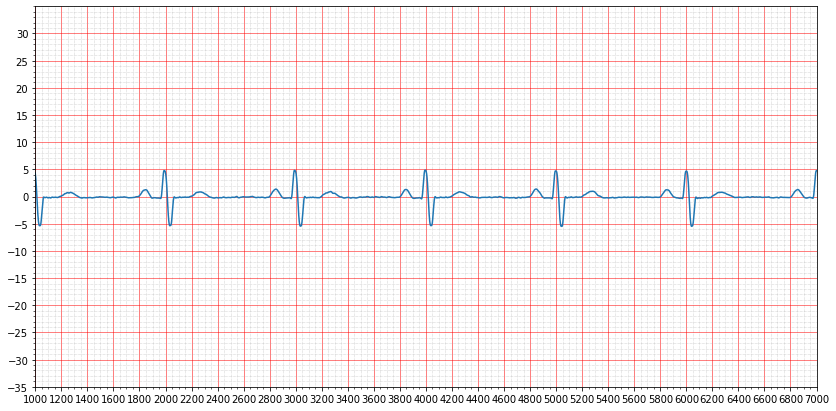

In [ ]:
#  As per Conventional Calibration
plt.figure(figsize=(7*2,3.5*2))
plt.plot(Lead1)
plt.xticks(np.arange(0, 15000, 200));
plt.yticks(np.arange(-35, 35, 5));
plt.xlim([1000,7000])
plt.ylim([-35,35])
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='darkgrey')
plt.minorticks_on()

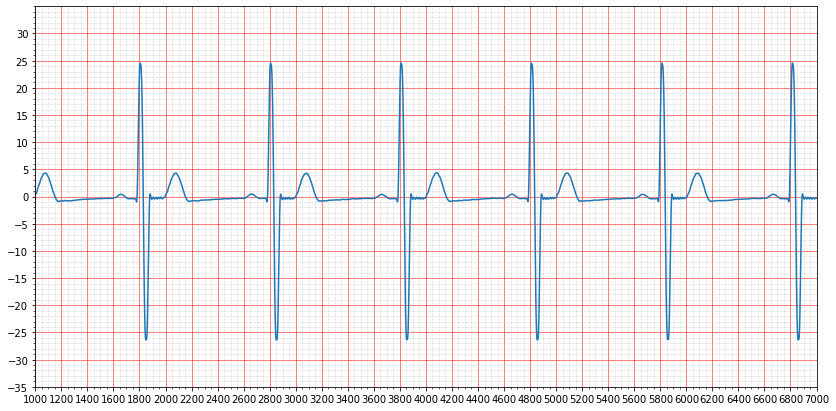

In [ ]:
#  As per Conventional Calibration
plt.figure(figsize=(7*2,3.5*2))
plt.plot(Lead1/2)
plt.xticks(np.arange(0, 15000, 200));
plt.yticks(np.arange(-35, 35, 5));
plt.xlim([1000,7000])
plt.ylim([-35,35])
plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='darkgrey')
plt.minorticks_on()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy import signal as sp
from google.colab import drive
drive.mount('/content/drive') 
###############################
# Use this code for data which is not stored in the csv format similar to Cloud upload

workspace = '/content/drive/My Drive/Colaboratory/csvdata/' # Location of the filepath
filename = 'Body ECG_UART data.csv' # Select a csv file stored in the above workspace path

Fs = 1000 # Sampling frequency
frequency = 1 # frequency of the signal
print('Signal Frequency -',frequency,' Hz')
plotting = 1 #change it 0, if plotting of signals is not required
###############################

#i = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [0],unpack = True) # Reading Column 0 from file
ii = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [1],unpack = True) # Reading Column 1 from file
iii = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [2],unpack = True) # Reading Column 2 from file
iv = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [3],unpack = True) # Reading Column 3 from file
v = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [4],unpack = True) # Reading Column 4 from file
vi = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [5],unpack = True) # Reading Column 5 from file
vii = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [6],unpack = True) # Reading Column 6 from file
viii = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [7],unpack = True) # Reading Column 7 from file

def func1(freq,sig,sd,z):
  
  '''
  Calculates the Minimum and maximum of the signal in given interval for evaluating the signal voltage for calibration. 

  freq - Frequency of the signal, int
  sig - Ecg lead, numpy array
  sd - starting index for calculation, int
  z - Lead name for display, str.

  >>>freq = 1
  >>>ecglead = i
  >>>startindex = 1000
  >>>z = 'Lead I'

  >>>func1(freq,ecglead,startindex,'Lead I')
  >>>Lead I 10 Peak to Peak Values array -  [225. 342. 467. 492. 442. 283. 218. 392. 370.]
  >>>Lead I Average Range - 359.000000
  >>>Lead I Average Voltage - 0.102674 mV
  '''
  quality = 100
  notchfreq = 50  
  ##### notch filter coment if needed 
  b, a = sp.iirnotch(notchfreq, quality, 1000); sig = sp.filtfilt(b, a, sig)

  startVal = sd
  interval = int(np.round(1000/freq))
  MaxValue = []
  MinValue = []

  for i in range(1,3):
    x1 = np.max(sig[startVal:(startVal+interval)])
    y1 = np.min(sig[startVal:(startVal+interval)])
    MaxValue.append(x1)
    MinValue.append(y1)
    startVal = startVal+interval
        
  x = np.asarray(MaxValue)
  y = np.asarray(MinValue)
  z = str(z)
  peak_to_peak = np.abs(x-y)
  adc_range_average = np.mean(peak_to_peak)
  volt_range = peak_to_peak*0.000286
  volt_range_average = np.mean(volt_range)
  #print('X',x)
  #print('Y',y)
  #print(peak_to_peak)
  print(z,'10 Peak to Peak Values array - ',peak_to_peak)
  print(z,'Average Range - %f'%(adc_range_average))
  print(z,'Average Voltage - %f'%(volt_range_average),'mV')
          
  return sig #peak_to_peak,adc_range_average,volt_range_average

xxx = 15

coli = func1(frequency,i,xxx,'I')
colii = func1(frequency,ii,xxx,'II')
coliii = func1(frequency,iii,xxx,'V1')
coliv = func1(frequency,iv,xxx,'V2')
v = func1(frequency,v,xxx,'V3')
vi = func1(frequency,vi,xxx,'V4')
vii = func1(frequency,vii,xxx,'V5')
viii = func1(frequency,viii,xxx,'V6')

if plotting == 1:
  fig = make_subplots(rows=4, cols=2,subplot_titles=("Column I","Column II","Column III","Column IV","Column V","Column VI","Column VII","Column VIII"))
  fig.add_trace(go.Scatter(x=((np.arange(1,len(i)+1))/Fs),y=i),row = 1,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(ii)+1))/Fs),y=ii),row = 2,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(iii)+1))/Fs),y=iii),row = 3,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(iv)+1))/Fs),y=iii),row = 4,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(v)+1))/Fs),y=iii),row = 1,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(vi)+1))/Fs),y=iii),row = 2,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(vii)+1))/Fs),y=iii),row = 3,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(viii)+1))/Fs),y=iii),row = 4,col = 2)
  fig.update_layout(height=1000, width=1000, title_text="All Columns")
  fig.show()

Mounted at /content/drive
Signal Frequency - 1  Hz


OSError: ignored

***Testing for Digitek CSV files***

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Signal Frequency - 1  Hz


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: DeprecationWarning:

Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.



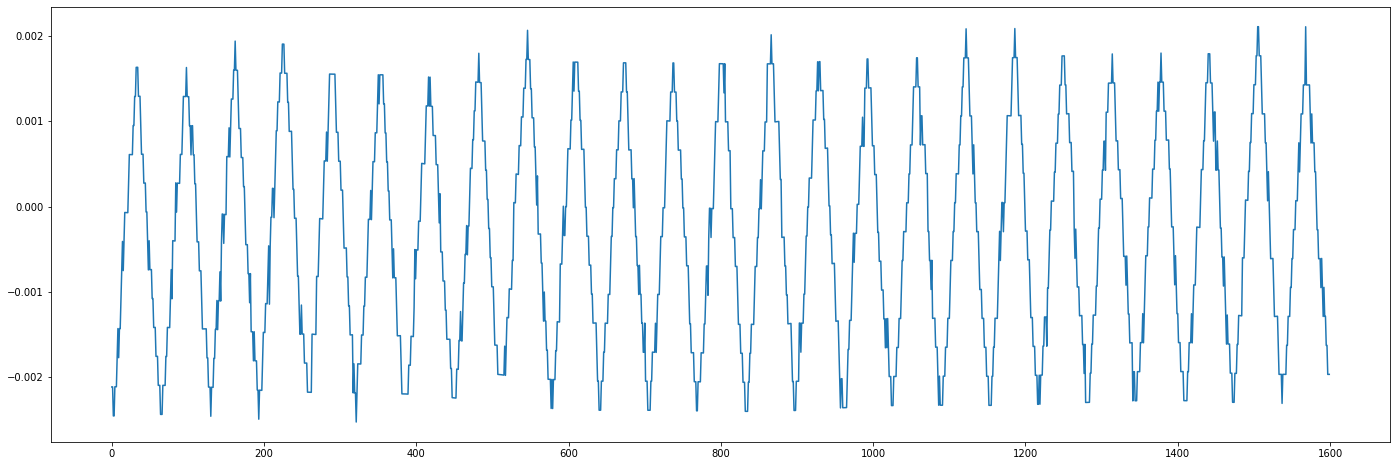

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import signal as sp
from google.colab import drive

import scipy
import matplotlib.pyplot as plt
#from scipy.signal import medfilt,lfilter,butter,filtfilt,spectrogram,periodogram,welch

drive.mount('/content/drive') 
###############################
# Use this code for data which is not stored in the csv format similar to Cloud upload

workspace = '/content/drive/MyDrive/250 Hz/100X, 2X1K Filter/Triangle/' # Location of the filepath
filename = 'SECG LA, 40 uV.csv' # Select a csv file stored in the above workspace path

FS = 80000 # Sampling frequency
frequency = 1 # frequency of the signal
print('Signal Frequency -',frequency,' Hz')
plotting = 1 #change it 0, if plotting of signals is not required
###############################


data = np.loadtxt(os.path.join(workspace,filename), delimiter = ',', skiprows = 14, usecols = [1],unpack = True) # Reading Column 2 from file
data = data[12:8192]


def func1(freq,sig,sd,z):

  quality = 100
  notchfreq = 50  
  ##### notch filter coment if needed 
  b, a = sp.iirnotch(notchfreq, quality, 1000); sig = sp.filtfilt(b, a, sig)

  startVal = sd
  interval = int(np.round(1000/freq))
  MaxValue = []
  MinValue = []

  for i in range(1,3):
    x1 = np.max(sig[startVal:(startVal+interval)])
    y1 = np.min(sig[startVal:(startVal+interval)])
    MaxValue.append(x1)
    MinValue.append(y1)
    startVal = startVal+interval
        
  x = np.asarray(MaxValue)
  y = np.asarray(MinValue)
  z = str(z)
  peak_to_peak = np.abs(x-y)
  adc_range_average = np.mean(peak_to_peak)
  volt_range = peak_to_peak*0.000286
  volt_range_average = np.mean(volt_range)
  #print('X',x)
  #print('Y',y)
  #print(peak_to_peak)
  print(z,'10 Peak to Peak Values array - ',peak_to_peak)
  print(z,'Average Range - %f'%(adc_range_average))
  print(z,'Average Voltage - %f'%(volt_range_average),'mV')
          
  return sig #peak_to_peak,adc_range_average,volt_range_average

N = len(data)
endpoint = int((N/2)+1)
freq_axis = (FS*np.arange(1,(N/2))/N)
#freq_axis = freq_axis -10
fft_lead1 = scipy.fft(data)
abs_lead1 = 2*(abs(np.array(fft_lead1))/N)
p_lead1 = abs_lead1[1:endpoint]

#plt.figure(figsize=(30, 6), dpi=80);plt.plot(freq_axis,p_lead1)
#plt.ylim(-15000, 25000);plt.xlim(0, 500)

b, a = sp.iirnotch(50, 0.5, 80000); sig1 = sp.filtfilt(b, a, data) 
d, c = sp.butter(4, [500/40000], 'low',analog=False); sig = sp.filtfilt(d, c, sig1) 

plt.figure(figsize=(24,8))
plt.plot(sig1[3000:4600])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

xxx = 15

coli = func1(frequency,i,xxx,'I')
colii = func1(frequency,ii,xxx,'II')
coliii = func1(frequency,iii,xxx,'V1')
coliv = func1(frequency,iv,xxx,'V2')
v = func1(frequency,v,xxx,'V3')
vi = func1(frequency,vi,xxx,'V4')
vii = func1(frequency,vii,xxx,'V5')
viii = func1(frequency,viii,xxx,'V6')

if plotting == 1:
  fig = make_subplots(rows=4, cols=2,subplot_titles=("Column I","Column II","Column III","Column IV","Column V","Column VI","Column VII","Column VIII"))
  fig.add_trace(go.Scatter(x=((np.arange(1,len(i)+1))/Fs),y=i),row = 1,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(ii)+1))/Fs),y=ii),row = 2,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(iii)+1))/Fs),y=iii),row = 3,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(iv)+1))/Fs),y=iii),row = 4,col = 1)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(v)+1))/Fs),y=iii),row = 1,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(vi)+1))/Fs),y=iii),row = 2,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(vii)+1))/Fs),y=iii),row = 3,col = 2)
  fig.add_trace(go.Scatter(x=((np.arange(1,len(viii)+1))/Fs),y=iii),row = 4,col = 2)
  fig.update_layout(height=1000, width=1000, title_text="All Columns")
  fig.show()

NameError: ignored